In [0]:
# My repo with data
!git clone https://github.com/Tixonmavrin/covid-19-solution

In [0]:
# Imports
import pandas as pd
import numpy as np
import copy
import lightgbm as lgb
from sklearn import metrics
import random

import os
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers
import matplotlib.pyplot as plt

# Change backend
os.environ["KERAS_BACKEND"] = "tensorflow"

# Dates
MIN_TEST = '2020-04-05'
MAX_TEST = '2020-04-29'

In [0]:
data = pd.read_csv('covid-19-solution/data/data_start/_data_confirmed.csv')
data_deaths = pd.read_csv('covid-19-solution/data/data_start/_data_deaths.csv')
data_rus = pd.read_csv('covid-19-solution/data/data_start/_data_confirmed_rus.csv')
data_deaths_rus = pd.read_csv('covid-19-solution/data/data_start/_data_deaths_rus.csv')

In [0]:
cols1 = list(data.columns[:2]) + [i for i in data.columns[2:] if (pd.to_datetime(i) < pd.to_datetime(MIN_TEST))]
data_train = data[cols1].append(data_rus[cols1])
data_deaths_train = data_deaths[cols1].append(data_deaths_rus[cols1])

cols2 = list(data.columns[:2]) + [i for i in data.columns[2:] if ((pd.to_datetime(i) >= pd.to_datetime(MIN_TEST)) & (pd.to_datetime(i) <= pd.to_datetime(MAX_TEST)))]
data_test = data[cols2].append(data_rus[cols2])
data_deaths_test = data_deaths[cols2].append(data_deaths_rus[cols2])

In [0]:
data_train2 = data_train.iloc[:,2:]
data_train2v = np.log1p(data_train2.values)
data_train2vt = (data_train2v - data_train2v.min()) / (data_train2v.max() - data_train2v.min())

data_deaths_train2 = data_deaths_train.iloc[:,2:]
data_deaths_train2v = np.log1p(data_deaths_train2.values)
data_deaths_train2vt = (data_deaths_train2v - data_deaths_train2v.min()) / (data_deaths_train2v.max() - data_deaths_train2v.min())

In [0]:
model = Sequential()
model.add(Dense(24, input_dim=data_train2vt.shape[1]))
model.add(Dropout(0.02))
model.add(Dense(data_train2vt.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

model_deaths = Sequential()
model_deaths.add(Dense(24, input_dim=data_deaths_train2vt.shape[1]))
model_deaths.add(Dropout(0.02))
model_deaths.add(Dense(data_deaths_train2vt.shape[1]))
model_deaths.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
# Also you can add noise or average days

model.fit(data_train2vt, data_train2vt, epochs=2000)
model_deaths.fit(data_deaths_train2vt, data_deaths_train2vt, epochs=2000)

Streaming output truncated to the last 5000 lines.
409/409 [==============================] - 0s 47us/step - loss: 1.7279e-04
Epoch 1502/2000
409/409 [==============================] - 0s 50us/step - loss: 1.9600e-04
Epoch 1503/2000
409/409 [==============================] - 0s 50us/step - loss: 2.3456e-04
Epoch 1504/2000
409/409 [==============================] - 0s 52us/step - loss: 1.6313e-04
Epoch 1505/2000
409/409 [==============================] - 0s 51us/step - loss: 1.8239e-04
Epoch 1506/2000
409/409 [==============================] - 0s 59us/step - loss: 1.3289e-04
Epoch 1507/2000
409/409 [==============================] - 0s 58us/step - loss: 1.6762e-04
Epoch 1508/2000
409/409 [==============================] - 0s 53us/step - loss: 1.7028e-04
Epoch 1509/2000
409/409 [==============================] - 0s 47us/step - loss: 1.8573e-04
Epoch 1510/2000
409/409 [==============================] - 0s 53us/step - loss: 1.7504e-04
Epoch 1511/2000
409/409 [==============================

In [0]:
X_transformed = model.predict(data_train2vt)
X_transformed = np.expm1(X_transformed * (data_train2v.max() - data_train2v.min()) + data_train2v.min())

X_deaths_transformed = model_deaths.predict(data_deaths_train2vt)
X_deaths_transformed = np.expm1(X_deaths_transformed * (data_deaths_train2v.max() - data_deaths_train2v.min()) + data_deaths_train2v.min())

In [0]:
data3 = np.expm1(model.predict((np.log1p(data.iloc[:, 2:len(cols1)]) - data_train2v.min()) / (data_train2v.max() - data_train2v.min())) * (data_train2v.max() - data_train2v.min()) + data_train2v.min())
data_rus3 = np.expm1(model.predict((np.log1p(data_rus.iloc[:, 2:len(cols1)]) - data_train2v.min()) / (data_train2v.max() - data_train2v.min())) * (data_train2v.max() - data_train2v.min()) + data_train2v.min())
data_deaths3 = np.expm1(model.predict((np.log1p(data_deaths.iloc[:, 2:len(cols1)]) - data_deaths_train2v.min()) / (data_deaths_train2v.max() - data_deaths_train2v.min())) * (data_deaths_train2v.max() - data_deaths_train2v.min()) + data_deaths_train2v.min())
data_deaths_rus3 = np.expm1(model.predict((np.log1p(data_deaths_rus.iloc[:, 2:len(cols1)]) - data_deaths_train2v.min()) / (data_deaths_train2v.max() - data_deaths_train2v.min())) * (data_deaths_train2v.max() - data_deaths_train2v.min()) + data_deaths_train2v.min())

In [0]:
data_cols = data.columns
data2 = []
for i in range(data.shape[0]):
  v = data.values[i]
  v[2:len(cols1)] = (v[2:len(cols1)] > 0).astype('int') * data3[i]
  data2.append(v)
data2 = pd.DataFrame(data2)
data2.columns = data_cols

In [0]:
data_rus_cols = data_rus.columns
data_rus2 = []
for i in range(data_rus.shape[0]):
  v = data_rus.values[i]
  v[2:len(cols1)] = (v[2:len(cols1)] > 0).astype('int') * data_rus3[i]
  data_rus2.append(v)
data_rus2 = pd.DataFrame(data_rus2)
data_rus2.columns = data_rus_cols

In [0]:
data_deaths_cols = data_deaths.columns
data_deaths2 = []
for i in range(data_deaths.shape[0]):
  v = data_deaths.values[i]
  v[2:len(cols1)] = (v[2:len(cols1)] > 0).astype('int') * data_deaths3[i]
  data_deaths2.append(v)
data_deaths2 = pd.DataFrame(data_deaths2)
data_deaths2.columns = data_deaths_cols

In [0]:
data_deaths_rus_cols = data_deaths_rus.columns
data_deaths_rus2 = []
for i in range(data_deaths_rus.shape[0]):
  v = data_deaths_rus.values[i]
  v[2:len(cols1)] = (v[2:len(cols1)] > 0).astype('int') * data_deaths_rus3[i]
  data_deaths_rus2.append(v)
data_deaths_rus2 = pd.DataFrame(data_deaths_rus2)
data_deaths_rus2.columns = data_deaths_rus_cols

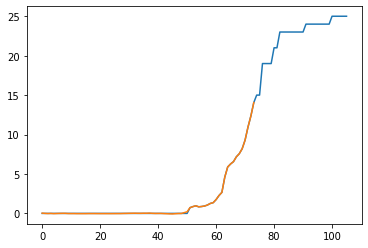

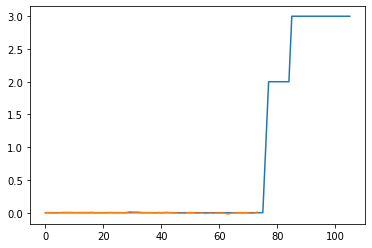

In [0]:
plt.plot(data2.values[5, 2:])
plt.plot(X_transformed[5])
plt.show()

plt.plot(data_deaths2.values[5, 2:])
plt.plot(X_deaths_transformed[5])
plt.show()

In [0]:
data2.to_csv('covid-19-solution/data/data_clean/_nonoice_data_confirmed.csv', index=False)
data_deaths2.to_csv('covid-19-solution/data/data_clean/_nonoice_data_deaths.csv', index=False)
data_rus2.to_csv('covid-19-solution/data/data_clean/_nonoice_data_confirmed_rus.csv', index=False)
data_deaths_rus2.to_csv('covid-19-solution/data/data_clean/_nonoice_data_deaths_rus.csv', index=False)